# Introduction

In this project, I play the role of a Data Analyst for an electric vehicle (EV) company. The company wants to understand recent trends in the global EV market and forecast future market trends, in order to identify potential opportunities. I'll analyze historical EV sales and break them down by a few different factors including geography, mode, and powertrain. From there, I'll use a couple different forecasting methods to see what the EV market may look like in the future if trends continue.

I'll primarily use historical EV sales data from the International Energy Agency (IEA). The IEA data is disaggregated by region (mostly country), mode (bus, car, truck, or van), powertrain (battery, plug-in hybrid, or fuel cell), and year (2010-2023). In order to analyze sales by continent, I'll use a separate table of countries and continents to map each country to its continent. The data sources can be found below:

- IEA: https://www.iea.org/data-and-statistics/data-tools/global-ev-data-explorer
- Continents: https://www.kaggle.com/datasets/hserdaraltan/countries-by-continent/data

The project is organized in 4 main parts:

1. Data Preparation and Cleaning
2. SQL Set-Up
3. Historical EV Market Trend Analysis
4. Future Opportunity Projections

By the end of the project, I'll aim to answer these guiding questions:

- What regions or countries have been driving the growth of EV sales in recent years?
- Has the EV market been dominated by certain modes or powertrains?
- If trends continue, what opportunities might exist for an EV company to capture value in the next 10 years?

# 1. Data Preparation and Cleaning

I'll start by reading the IEA data into Python for exploration and cleaning. The data is actually broken down into 4 separate tables by mode, so there is one table each for buses, cars, trucks, and vans. Let's read each of them into a Pandas DataFrame and preview them.

In [3]:
# Import necessary libraries
import os
import pandas as pd
import matplotlib.pyplot as plt

os.chdir("/Users/macbook/Documents/data_projects/ev_markets")

# Read in each table
buses = pd.read_csv("IEA-EV-dataEV salesHistoricalBuses.csv")
cars = pd.read_csv("IEA-EV-dataEV salesHistoricalCars.csv")
trucks = pd.read_csv("IEA-EV-dataEV salesHistoricalTrucks.csv")
vans = pd.read_csv("IEA-EV-dataEV salesHistoricalVans.csv")

# Use a for loop to preview all the tables
modes = {
    "Buses": buses,
    "Cars": cars,
    "Trucks": trucks,
    "Vans": vans
}

for name, mode in modes.items():
    print(f"Preview of {name}")
    print(mode.info())
    print(mode.head())
    print("\n")

Preview of Buses
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1813 entries, 0 to 1812
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   region      1813 non-null   object 
 1   category    1813 non-null   object 
 2   parameter   1813 non-null   object 
 3   mode        1813 non-null   object 
 4   powertrain  1813 non-null   object 
 5   year        1813 non-null   int64  
 6   unit        1813 non-null   object 
 7   value       1813 non-null   float64
dtypes: float64(1), int64(1), object(6)
memory usage: 113.4+ KB
None
    region    category       parameter   mode powertrain  year      unit  \
0  Belgium  Historical        EV stock  Buses        BEV  2010  Vehicles   
1  Belgium  Historical  EV stock share  Buses         EV  2010   percent   
2  Belgium  Historical  EV stock share  Buses         EV  2011   percent   
3  Belgium  Historical        EV stock  Buses        BEV  2011  Vehicles   
4  Belgium  Histor

Each table seems to follow a similar pattern. They each have 8 columns which to be in the same order. All columns are object types except for "year" and "value" which are numeric. It seems there aren't any issues with missing data, which is great. Looking at each table, it seems there will be multiple lines for each "region" in each "year" based on the "parameter" column. For example, in the "cars" table, Australia has 4 entries for 2011: one each for EV sales, EV stock share, EV sales share, and EV stock. The corresponding units in the "unit" column also changed based on the "parameter." I'll need to be mindful of this when writing SQL queries, especially when using aggregate functions and grouping clauses.

I'd like to combine all 4 tables into 1 table before reading it into SQL. It helps that each table already has a "mode" column, so we won't have to add this before concatenating the tables together. But first, I'll check more closley to make sure all the tables in fact have the same columns in the same order.

In [5]:
for name, mode in modes.items():
    print(f"{name} columns:")
    print(mode.columns)

Buses columns:
Index(['region', 'category', 'parameter', 'mode', 'powertrain', 'year', 'unit',
       'value'],
      dtype='object')
Cars columns:
Index(['region', 'category', 'parameter', 'mode', 'powertrain', 'year', 'unit',
       'value'],
      dtype='object')
Trucks columns:
Index(['region', 'category', 'parameter', 'mode', 'powertrain', 'year', 'unit',
       'value'],
      dtype='object')
Vans columns:
Index(['region', 'category', 'parameter', 'mode', 'powertrain', 'year', 'unit',
       'value'],
      dtype='object')


It looks like all the tables have the same columns, so let's go ahead and concatenate them into 1 table. After concatenating, I'll check to make sure all the rows were successfully included.

In [7]:
evs = pd.concat([buses, cars, trucks, vans], ignore_index=True)

# Check the length of each table separately, and make sure they add up to the total in the combined table
for name, mode in modes.items():
    print(f"Rows in {name}: {mode.shape[0]}")

print("\n")

print(f"Rows in all modes separately: {buses.shape[0] + cars.shape[0] + trucks.shape[0] + vans.shape[0]}")
print(f"Rows in concatenated DataFrame: {evs.shape[0]}")

Rows in Buses: 1813
Rows in Cars: 3798
Rows in Trucks: 1028
Rows in Vans: 1783


Rows in all modes separately: 8422
Rows in concatenated DataFrame: 8422


Based on the output above, we can see that all 8,422 rows from the 4 different tables were successfully concatenated into 1 table. Next, let's explore a bit more about the values in each column.

In [9]:
for column in list(evs.columns):
    print(evs[column].value_counts())
    print("\n")

region
World                   578
Europe                  567
China                   484
EU27                    397
France                  334
Netherlands             330
Rest of the world       324
United Kingdom          320
Denmark                 295
Belgium                 288
Germany                 274
USA                     257
Sweden                  251
Norway                  243
Japan                   236
Spain                   222
Switzerland             221
Canada                  216
India                   212
Italy                   206
Korea                   193
Finland                 178
Poland                  174
New Zealand             172
Brazil                  171
Portugal                163
Israel                  132
Iceland                  96
Austria                  90
Australia                82
Chile                    77
Mexico                   70
South Africa             69
Turkiye                  64
Greece                   62
Latvia       

First, the "region" column appears to mostly have country names, although it does have a few aggregated entities such as "EU27" and "Rest of the world." I'll likely get rid of these extra aggregated entities since they don't account for all countries and I'll be doing my own aggregation by continent later, but I'll handle this a bit later. We've already spoken a bit about the "parameter" and "mode" columns. We can see that "powertrain" includes "BEV" (battery electric vehicle), "PHEV" (plug-in hybrid electric vehicle), and "FCEV" (fuel cell electric vehicle). Finally, as expected, "year" ranges from 2010 to 2023.

Next, since I'll be working primarily with EV sales, I want to check the values of the "EV sales" rows for any non-whole numbers (it doesn't make sense to sell a fraction of a vehicle).

In [11]:
value_check = evs[(evs["parameter"] == "EV sales") & (evs["value"] % 1 != 0)]
print(value_check)

           region    category parameter   mode powertrain  year      unit  \
783        Israel  Historical  EV sales  Buses        BEV  2013  Vehicles   
1565          USA  Historical  EV sales  Buses        BEV  2012  Vehicles   
1572          USA  Historical  EV sales  Buses        BEV  2013  Vehicles   
4138  Netherlands  Historical  EV sales   Cars       FCEV  2014  Vehicles   

      value  
783   0.001  
1565  6.500  
1572  8.700  
4138  2.200  


It looks like there are just a few rows of EV sales with non-whole numbers. These might be errors in the original dataset. For my purposes, I'll just round these EV sales values to zero decimal places.

In [13]:
evs.loc[evs["parameter"] == "EV sales", "value"] = evs.loc[evs["parameter"] == "EV sales", "value"].round(0)
value_check_2 = evs[(evs["parameter"] == "EV sales") & (evs["value"] % 1 != 0)]
print(value_check_2)

Empty DataFrame
Columns: [region, category, parameter, mode, powertrain, year, unit, value]
Index: []


That worked. As we can see in the output above, when checking the second time (after rounding), there are no rows of EV sales where the value is a non-whole number. Next, as mentioned before, I'll work on the "region" column. Since I'm going to focus just on the country-specific rows in this table, I'll rename the "region" column to "country".

In [15]:
evs = evs.rename(columns={"region": "country"})
print(evs.columns)

Index(['country', 'category', 'parameter', 'mode', 'powertrain', 'year',
       'unit', 'value'],
      dtype='object')


I'm curious to see how many different countries are in the dataset. Let's check the length of the list of unique country names in our table, keeping in mind that a few of these are aggregated entities but the majority are specific countries.

In [17]:
len(evs["country"].unique())

52

We have about 50 or so different countries in our IEA data. At some point I'll want to analyze by continent, but continent is not included in the IEA data, so we'll read in a separate table of countries and continents that we can use to join continents. This one comes from Kaggle, as mentioned in the Introduction.

In [19]:
# Read in and preview the continents dataset
continents = pd.read_csv("continents.csv")
continents.info()
continents.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   continent  196 non-null    object
 1   country    196 non-null    object
dtypes: object(2)
memory usage: 3.2+ KB


,continent,country
0,Africa,Algeria
1,Africa,Angola
2,Africa,Benin
3,Africa,Botswana
4,Africa,Burkina


I want to check to make sure all the countries from the IEA data map cleanly to a country-continent pair in the continents table. There may be spelling errors or naming conventions that differ across the 2 tables. Let's check and see what differences there might be.

In [21]:
# Create a set of country names in both tables and use subtraction to check discrepancies
countries_in_evs = set(evs["country"])
countries_in_continents = set(continents["country"])
missing_countries = countries_in_evs - countries_in_continents

if missing_countries:
    print("Missing countries:", missing_countries)
else:
    print("All countries are present in the continent mapping.")

Missing countries: {'Turkiye', 'Europe', 'Rest of the world', 'USA', 'EU27', 'Czech Republic', 'Korea', 'World'}


As we can see from the output above, there are 8 country names from the IEA data that aren't found in the "continents" table. I'll change the names of the countries so they match. For the non-country entities, I'll go ahead and filter them out now.

In [23]:
# Filter out the non-country entities
evs = evs[~evs["country"].isin(["EU27", "World", "Rest of the world", "Europe"])]

# Align country names with different naming conventions
evs.replace({
    "Czech Republic": "Czechia",
    "Korea": "South Korea",
    "USA": "United States"
}, inplace=True)

continents.replace({
    "Turkey": "Turkiye"
}, inplace=True)

# Check again to make sure discrepancies have been eliminated
countries_in_evs_2 = set(evs["country"])
countries_in_continents_2 = set(continents["country"])
missing_countries_2 = countries_in_evs_2 - countries_in_continents_2

if missing_countries_2:
    print("Missing countries:", missing_countries_2)
else:
    print("All countries are present in the continent mapping.")

All countries are present in the continent mapping.


Great! Now we've standardized the country names across the "evs" table and the "continents" table and filtered out the non-country entities. At this point, our data is pretty clean and ready to be read into SQL.

# 2. SQL Set-Up

Next, I'll read the 2 tables into PostgreSQL.

In [25]:
!pip install sqlalchemy psycopg2-binary

In [26]:
from sqlalchemy import create_engine

username = "postgres"
password = "password1"
host = "localhost"
port = "5432"
database = "ev_markets_db"

# Initialize the connection to PostgreSQL
engine = create_engine(f"postgresql://{username}:{password}@{host}:{port}/{database}")

# Read in the 2 tables
evs.to_sql("evs", con=engine, if_exists='replace', index=False)
continents.to_sql("continents", con=engine, if_exists='replace', index=False)

print("Data successfully loaded into ev_markets_db.")

Data successfully loaded into ev_markets_db.


As a quick check, I know there should be 48 unique values in the "country" column of "evs", since we removed 4 non-country entities. Let's query the SQL database to make sure the "evs" table has 48 unique countries.

In [28]:
check_query = """

SELECT COUNT(DISTINCT country) AS unique_region_count
  FROM evs;

"""

check_result = pd.read_sql(check_query, con=engine)
print(check_result)


   unique_region_count
0                   48


Looks good! Let's proceed to our analysis.

# 3. Historical EV Market Trend Analysis

To analyze the historical EV market trends, I'll break down EV sales by continent, country, mode, and powertrain. For each of these factors, I'll look both overall (total sales for the 14-year time period) as well as year-by-year to get a sense of growth patterns. Let's start with continents.

## Continents

       Continent  Total EVs Sold (2010-2023)  Percent Share
0           Asia                  25,035,359             59
1         Europe                  11,653,826             27
2  North America                   5,420,221             13
3        Oceania                     286,339              1
4  South America                     114,660              0
5         Africa                       3,801              0




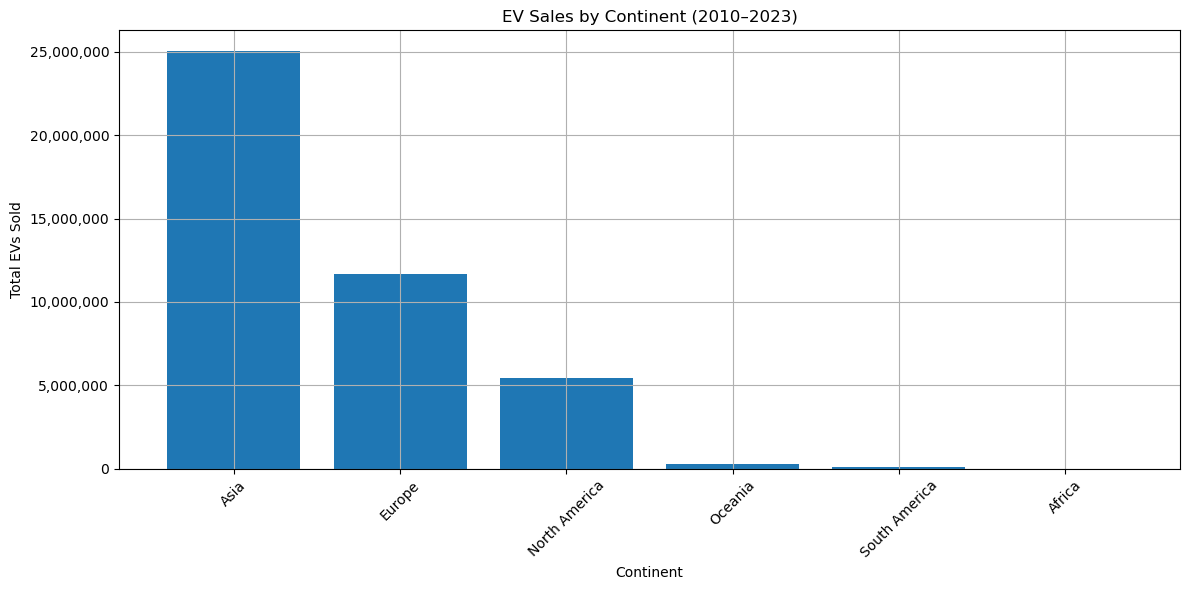

In [30]:
# Query to pull total EV sales grouped by continent
continents_total_query = """

SELECT c.continent AS "Continent",
       SUM(e.value) AS "Total EVs Sold (2010-2023)",
       ROUND(CAST(SUM(e.value) * 100.0 / SUM(SUM(e.value)) OVER () AS numeric), 1) AS "Percent Share"
  FROM evs AS e
  JOIN continents AS c
    ON e.country = c.country
 WHERE e.parameter = 'EV sales'
 GROUP BY c.continent
 ORDER BY SUM(e.value) DESC;

"""

continents_total_result = pd.read_sql(continents_total_query, con=engine)

# Set number formatting for Pandas DataFrames to display full numbers rather than scientific notation
pd.set_option('display.float_format', '{:,.0f}'.format)

print(continents_total_result)
print("\n")

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Set formatting to use for y-axes to show full numbers rather than scientific notation
formatter = FuncFormatter(lambda x, _: f"{int(x):,}")

fig, ax = plt.subplots(figsize=(12, 6))

# Create bar chart
plt.bar(continents_total_result["Continent"], continents_total_result["Total EVs Sold (2010-2023)"])
ax.yaxis.set_major_formatter(formatter)
plt.title("EV Sales by Continent (2010–2023)")
plt.ylabel("Total EVs Sold")
plt.xlabel("Continent")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

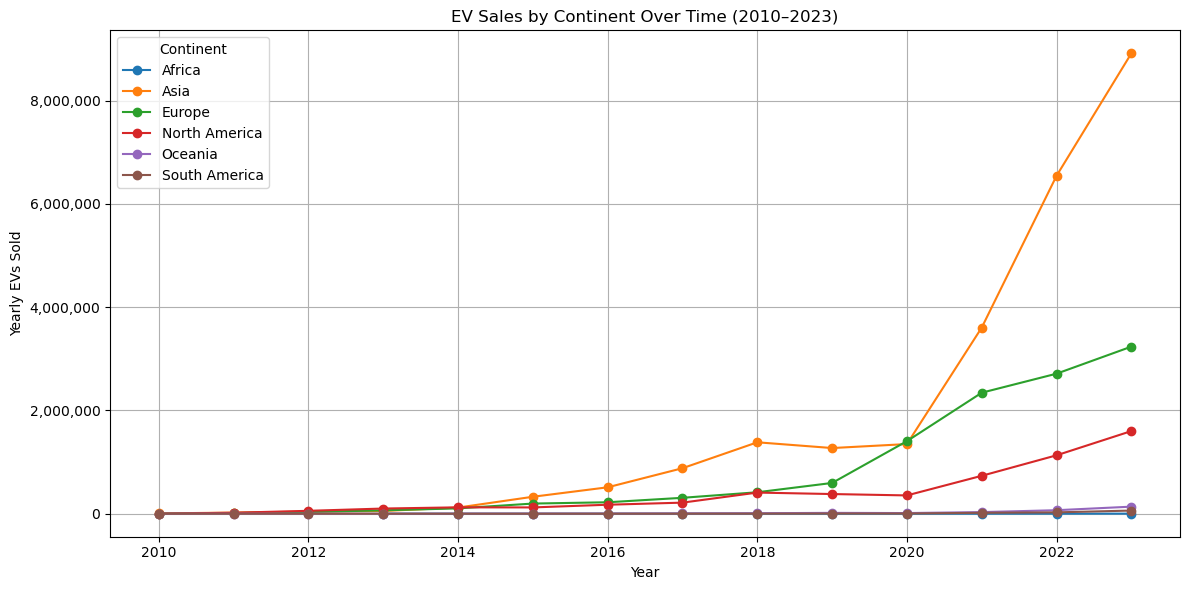

In [31]:
# Query to pull EV sales by year, grouped by continent
continents_yearly_query = """

SELECT c.continent AS "Continent",
       e.year AS "Year",
       SUM(e.value) AS "Total EVs Sold"
  FROM evs AS e
  JOIN continents AS c
    ON e.country = c.country
 WHERE e.parameter = 'EV sales'
 GROUP BY c.continent, e.year
 ORDER BY c.continent, e.year;

"""

continents_yearly_result = pd.read_sql(continents_yearly_query, con=engine)

# Pivot the resulting DataFrame on 'Year'
continents_yearly_pivot = continents_yearly_result.pivot(index="Year", columns="Continent", values="Total EVs Sold")

# Create line plot to show EV sales by year for each continent
ax = continents_yearly_pivot.plot(kind='line', marker='o', figsize=(12, 6))
ax.yaxis.set_major_formatter(formatter)
plt.title("EV Sales by Continent Over Time (2010–2023)")
plt.ylabel("Yearly EVs Sold")
plt.xlabel("Year")
plt.grid(True)
plt.tight_layout()

We can see that the global EV market is dominated by sales in Asia, Europe, and North America. Asian sales accounted for 59% of the global total between 2010 and 2023. Europe came in second at 27%, followed by North America at 13%. The remaining 3 continents - Oceania, South America, and Africa - each accounted for just about 1% or less of the global total. When looking at year-by-year growth, we see a striking trend. EV sales across all continents were at relatively similar levels until about 2016 and then started to diverge. In particular, sales in Asia skyrocketed after 2020. Europe and North American markets also grew steadily since then, but the Asian market has been the clear leader in growth in the past few years. 

Let's dig into this more by seeing sales by country.

## Countries

          Country  Total EVs Sold (2010-2023)  Percent Share
0           China                  23,358,308             55
1   United States                   4,770,934             11
2         Germany                   3,012,826              7
3          France                   1,666,650              4
4  United Kingdom                   1,659,853              4
5          Norway                     879,813              2
6          Sweden                     706,166              2
7     Netherlands                     679,595              2
8     South Korea                     676,352              2
9           Japan                     627,730              2




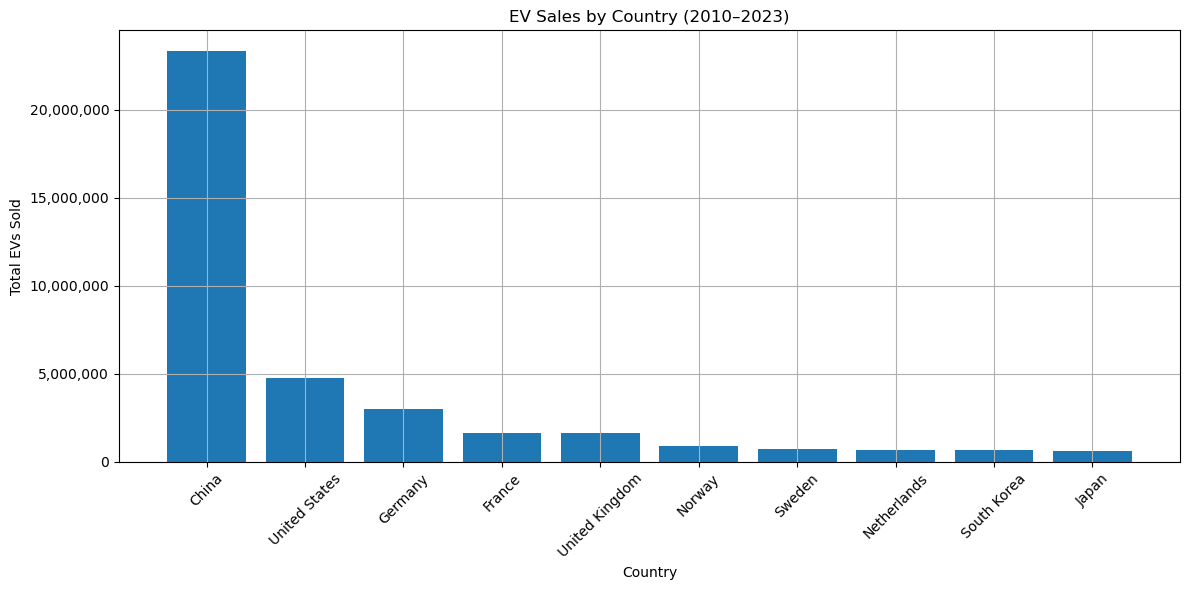

In [33]:
countries_total_query = """

SELECT country AS "Country",
       SUM(value) AS "Total EVs Sold (2010-2023)",
       ROUND(CAST(SUM(value) * 100.0 / SUM(SUM(value)) OVER () AS numeric), 1) AS "Percent Share"
  FROM evs
 WHERE parameter = 'EV sales'
 GROUP BY country
 ORDER BY SUM(value) DESC
 LIMIT 10;

"""

countries_total_result = pd.read_sql(countries_total_query, con=engine)
print(countries_total_result)
print("\n")

fig, ax = plt.subplots(figsize=(12, 6))

plt.bar(countries_total_result["Country"], countries_total_result["Total EVs Sold (2010-2023)"])
ax.yaxis.set_major_formatter(formatter)
plt.title("EV Sales by Country (2010–2023)")
plt.ylabel("Total EVs Sold")
plt.xlabel("Country")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

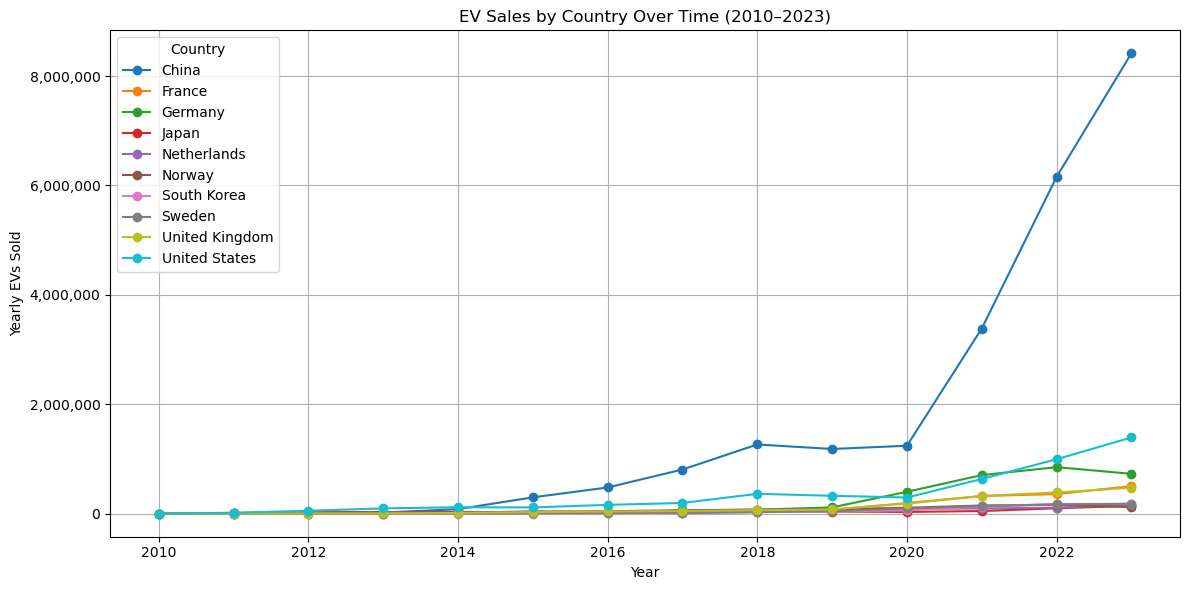

In [34]:
countries_yearly_query = """

SELECT country AS "Country",
       year AS "Year",
       SUM(value) AS "Total EVs Sold"
  FROM evs
 WHERE parameter = 'EV sales' AND country IN (
       SELECT country
         FROM evs
        WHERE parameter = 'EV sales'
        GROUP BY country
        ORDER BY SUM(value) DESC
        LIMIT 10
        )
 GROUP BY country, year
 ORDER BY country, year;

"""

countries_yearly_result = pd.read_sql(countries_yearly_query, con=engine)

countries_yearly_pivot = countries_yearly_result.pivot(index="Year", columns="Country", values="Total EVs Sold")

ax = countries_yearly_pivot.plot(kind='line', marker='o', figsize=(12, 6))
ax.yaxis.set_major_formatter(formatter)
plt.title("EV Sales by Country Over Time (2010–2023)")
plt.ylabel("Yearly EVs Sold")
plt.xlabel("Year")
plt.grid(True)
plt.tight_layout()

Looking at EV sales by country, we can notice a couple important trends. First, the Asian and North American markets are primarily driven by one country in each continent: China and the United States, respectively. Meanwhile, the European market is a bit more diversified, with sales spread across Germany, France, the United Kingdom, and others. Second, because the Asian and North American markets are so dominated by one country, the country growth trends tend to mirror the trends by continent. China emerges as the clear leader in EV sales, with that lead widening dramatically since 2020. All in all, more than 23 million EV's were sold in China over the 14-year time period, accounting for 55% of the global total. Sales have grown steadily in the United States too, but nowhere near as quickly as in China.

Now that we've tackled geographic trends, let's look at a couple other factors, starting with modes (buses, cars, trucks, and vans).

## Modes

     Mode  Total EVs Sold (2010-2023)  Percent Share
0    Cars                  40,244,560             95
1    Vans                   1,305,968              3
2   Buses                     627,374              2
3  Trucks                     336,304              1




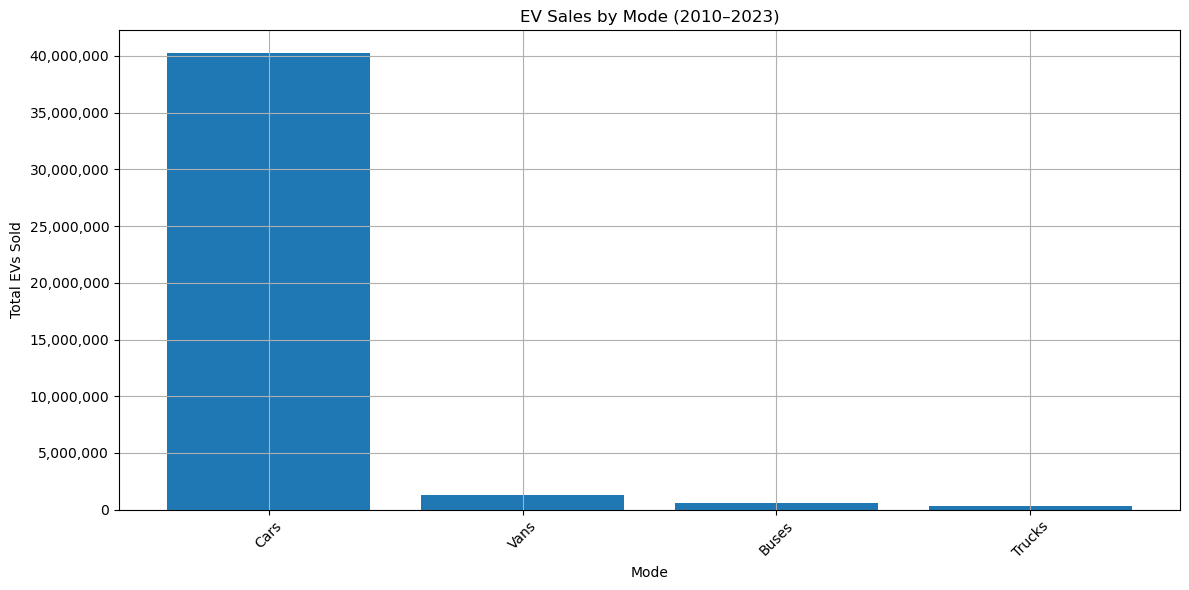

In [36]:
modes_total_query = """

SELECT mode AS "Mode",
       SUM(value) AS "Total EVs Sold (2010-2023)",
       ROUND(CAST(SUM(value) * 100.0 / SUM(SUM(value)) OVER () AS numeric), 1) AS "Percent Share"
  FROM evs
 WHERE parameter = 'EV sales'
 GROUP BY mode
 ORDER BY SUM(value) DESC;

"""

modes_total_result = pd.read_sql(modes_total_query, con=engine)
print(modes_total_result)
print("\n")

fig, ax = plt.subplots(figsize=(12, 6))

plt.bar(modes_total_result["Mode"], modes_total_result["Total EVs Sold (2010-2023)"])
ax.yaxis.set_major_formatter(formatter)
plt.title("EV Sales by Mode (2010–2023)")
plt.ylabel("Total EVs Sold")
plt.xlabel("Mode")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

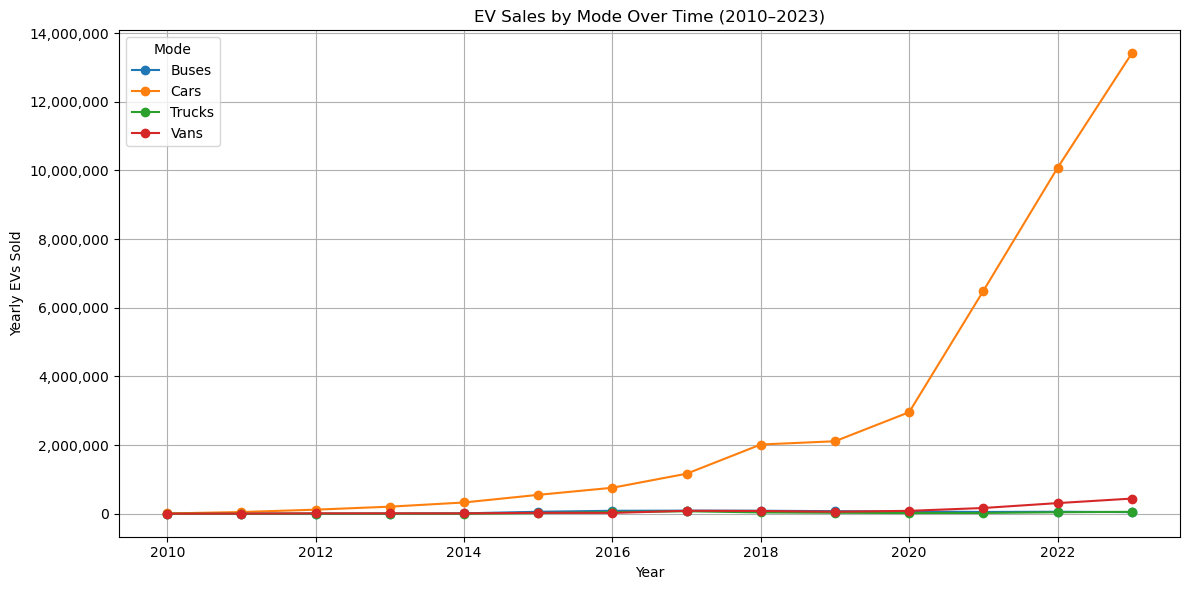

In [37]:
modes_yearly_query = """

SELECT mode AS "Mode",
       year AS "Year",
       SUM(value) AS "Total EVs Sold"
  FROM evs
 WHERE parameter = 'EV sales'
 GROUP BY mode, year
 ORDER BY mode, year

"""

modes_yearly_result = pd.read_sql(modes_yearly_query, con=engine)

modes_yearly_pivot = modes_yearly_result.pivot(index="Year", columns="Mode", values="Total EVs Sold")

ax = modes_yearly_pivot.plot(kind='line', marker='o', figsize=(12, 6))
ax.yaxis.set_major_formatter(formatter)
plt.title("EV Sales by Mode Over Time (2010–2023)")
plt.ylabel("Yearly EVs Sold")
plt.xlabel("Year")
plt.grid(True)
plt.tight_layout()

In terms of mode, the trend in the IEA data is pretty straightfoward. The vast majority of the growth in EV sales in recent years is due to cars, while the other modes (buses, trucks, and vans) have not moved much. Over the 14-year time period, cars accounted for 95% of globale EV sales. Next, let's look at powertrains.

## Powertrains

  Powertrain  Total EVs Sold (2010-2023)  Percent Share
0        BEV                  30,110,768             71
1       PHEV                  12,314,143             29
2       FCEV                      89,295              0




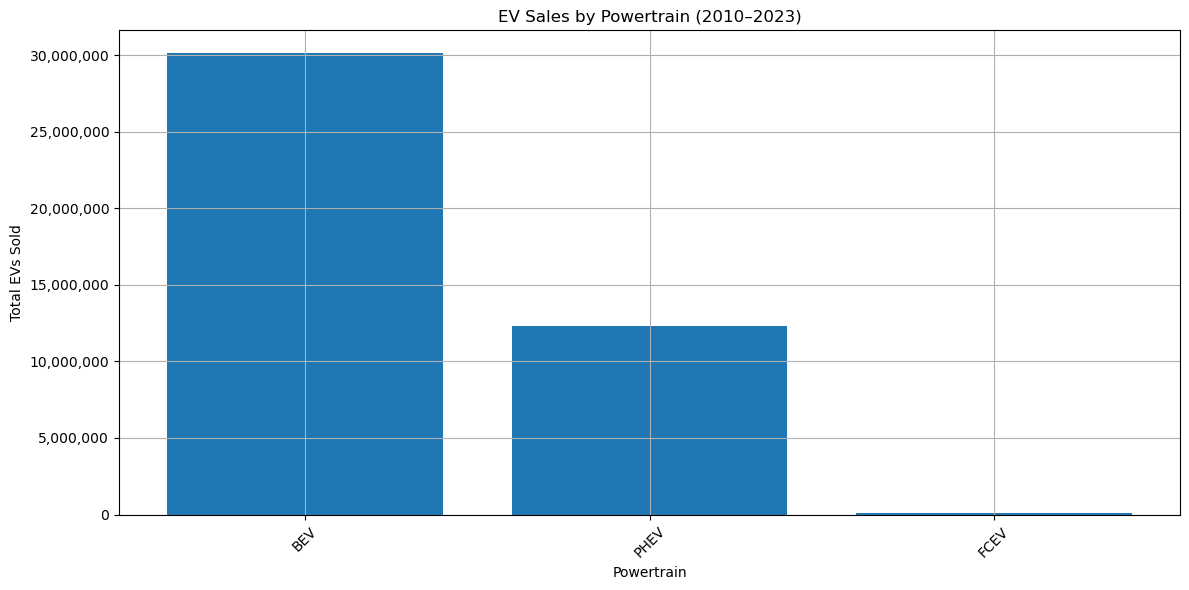

In [39]:
powertrains_total_query = """

SELECT powertrain AS "Powertrain",
       SUM(value) AS "Total EVs Sold (2010-2023)",
       ROUND(CAST(SUM(value) * 100.0 / SUM(SUM(value)) OVER () AS numeric), 1) AS "Percent Share"
  FROM evs
 WHERE parameter = 'EV sales'
 GROUP BY powertrain
 ORDER BY SUM(value) DESC;

"""

powertrains_total_result = pd.read_sql(powertrains_total_query, con=engine)
print(powertrains_total_result)
print("\n")

fig, ax = plt.subplots(figsize=(12, 6))

plt.bar(powertrains_total_result["Powertrain"], powertrains_total_result["Total EVs Sold (2010-2023)"])
ax.yaxis.set_major_formatter(formatter)
plt.title("EV Sales by Powertrain (2010–2023)")
plt.ylabel("Total EVs Sold")
plt.xlabel("Powertrain")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

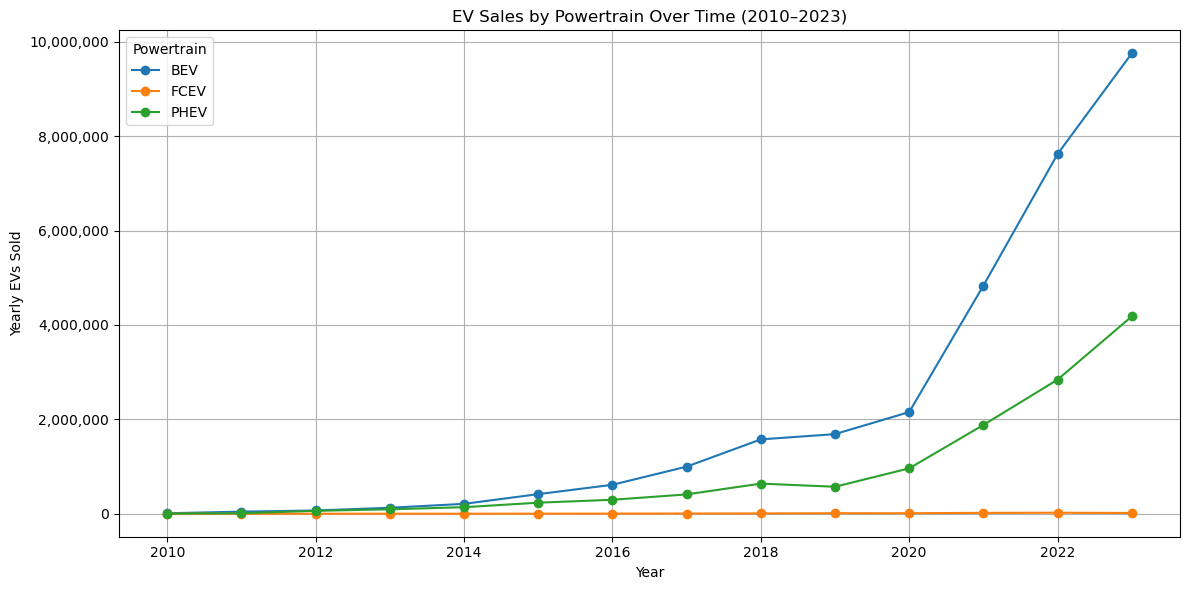

In [40]:
powertrains_yearly_query = """

SELECT powertrain AS "Powertrain",
       year AS "Year",
       SUM(value) AS "Total EVs Sold"
  FROM evs
 WHERE parameter = 'EV sales'
 GROUP BY powertrain, year
 ORDER BY powertrain, year

"""

powertrains_yearly_result = pd.read_sql(powertrains_yearly_query, con=engine)

powertrains_yearly_pivot = powertrains_yearly_result.pivot(index="Year", columns="Powertrain", values="Total EVs Sold")

ax = powertrains_yearly_pivot.plot(kind='line', marker='o', figsize=(12, 6))
ax.yaxis.set_major_formatter(formatter)
plt.title("EV Sales by Powertrain Over Time (2010–2023)")
plt.ylabel("Yearly EVs Sold")
plt.xlabel("Year")
plt.grid(True)
plt.tight_layout()

Compared to modes, the distribution of powertrains is a bit more balanced. Battery electric vehicles (BEV's) accounted for 71% of global EV sales over the time period, with plug-in hybrids (PHEV's) making up 29%. Fuel cell electric vehicles (FCEV's) accounted for less than 1%. In terms of growth patterns, BEV's and PHEV's appear to have roughly similar trajectories. Both have grown steadily since about 2016 and taken off more since 2020.

As one final check, it would be interesting to see if the twin growth of BEV's and PHEV's is present in China, as the leading country in the EV market, or if Chinese EV sales tend to favor one powertrain or the other. Let's check this out.

## Powertrains in China

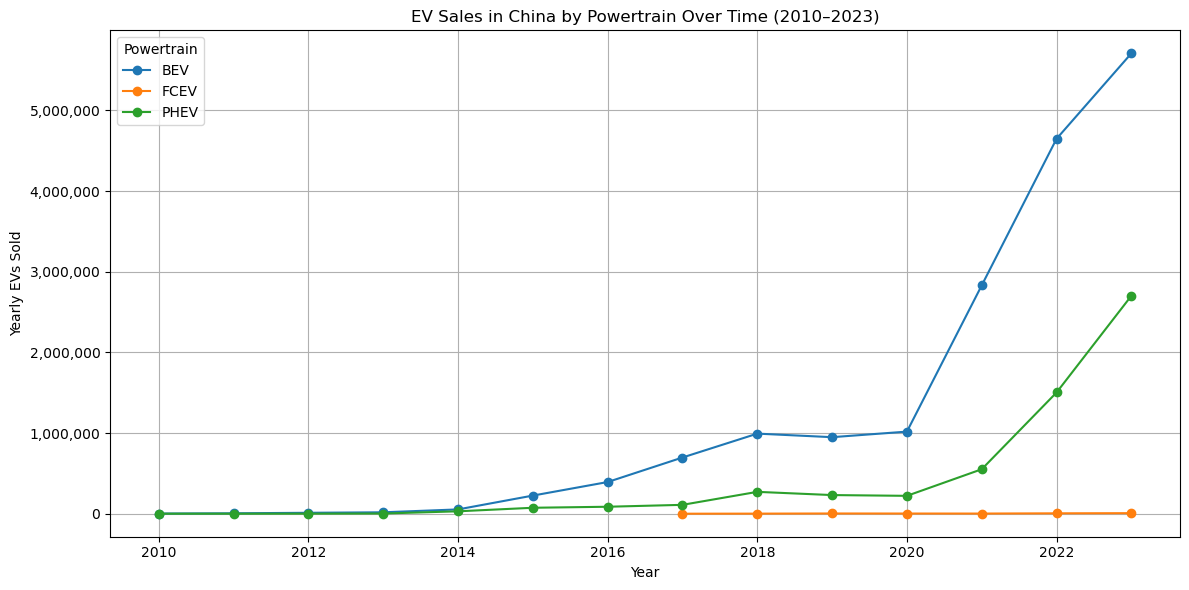

In [42]:
# Query to pull EV sales by year in China for each powertrain
powertrains_china_yearly_query = """

SELECT powertrain AS "Powertrain",
       year AS "Year",
       SUM(value) AS "Total EVs Sold"
  FROM evs
 WHERE parameter = 'EV sales' AND country = 'China'
 GROUP BY powertrain, year
 ORDER BY powertrain, year

"""

powertrains_china_yearly_result = pd.read_sql(powertrains_china_yearly_query, con=engine)

powertrains_china_yearly_pivot = powertrains_china_yearly_result.pivot(index="Year", columns="Powertrain", values="Total EVs Sold")

ax = powertrains_china_yearly_pivot.plot(kind='line', marker='o', figsize=(12, 6))
ax.yaxis.set_major_formatter(formatter)
plt.title("EV Sales in China by Powertrain Over Time (2010–2023)")
plt.ylabel("Yearly EVs Sold")
plt.xlabel("Year")
plt.grid(True)
plt.tight_layout()

Based on the graph above, at first glance it looks like powertrain growth trends in China seem to mirror the rest of the world. THe market is mostly driven by BEV's with a smaller, but still important, role for PHEV's.

## Summary of Historical Market Trends

At this stage of the project, we can answer a couple of the guiding questions we laid out in the Introduction:

- What regions or countries have been driving the growth of EV sales in recent years?
- Has the EV market been dominated by certain modes or powertrains?

EV sales have increased tremendously since 2020. This growth was driven primarily by China. There has been some growth in the United States and Europe, but China is by far outpacing the rest of the world. Furthermore, most of the growth has been in BEV's, but PHEV's have shown solid growth too. Finally, global EV sales are dominated by cars rather than buses, trucks, or vans.

# 4. Future Opportunity Projections

In this section, we'll attempt to answer the last of the guiding questions:

- If trends continue, what opportunities might exist for an EV company to capture value in the next 10 years?

The major trends we identified in the historical analysis were related to sales volume by country and market share by powertrain. Let's attempt to forecast what the global EV market may look like in the next 10 years, if these trends were to continue.

## Projected EV Sales Volume by Country

Projected 2033 EV Sales in China: 20,185,077
Projected 2033 EV Sales in United States: 3,191,392
Projected 2033 EV Sales in Germany: 1,667,796
Projected 2033 EV Sales in France: 1,148,179
Projected 2033 EV Sales in United Kingdom: 1,083,457


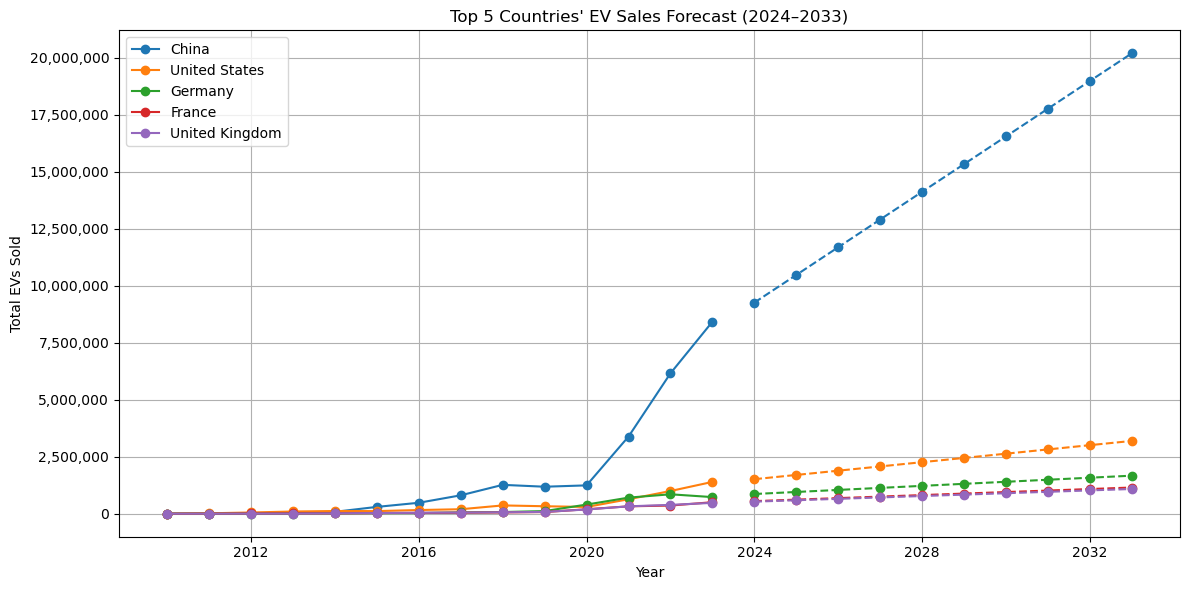

In [44]:
# Import tools for exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import itertools

plt.figure(figsize=(12, 6))

# Set consistent colors so each country has the same color for its historical and future plots
color_cycle = plt.cm.tab10.colors
color_iterator = itertools.cycle(color_cycle)
country_colors = {}

# Use the previous query of total EV sales by country to identify the top 5
top_5_countries = countries_total_result["Country"].head(5).to_list()

# Loop through each of the top 5 countries
for country in top_5_countries:
    
    # Set each country's color for the graph
    if country not in country_colors:
        country_colors[country] = next(color_iterator)
    
    color = country_colors[country]

    # Pull each country's historical EV sales by year
    country_sales_query = f"""
    
    SELECT country AS "Country",
           year AS "Year",
           SUM(value) AS "Total EVs Sold"
      FROM evs
     WHERE parameter = 'EV sales' AND country = '{country}'
     GROUP BY country, year
     ORDER BY year;
    
    """

    country_sales = pd.read_sql(country_sales_query, con=engine)

    # Prepare the date/time properties for exponential smoothing
    country_sales["Year"] = pd.to_datetime(country_sales["Year"], format="%Y")
    country_sales.set_index("Year", inplace=True)
    country_sales.index.freq = 'YS' 

    # Set the initial level and trend for the model
    init_level = country_sales["Total EVs Sold"].iloc[0]
    init_trend = (country_sales["Total EVs Sold"].iloc[-1] - country_sales["Total EVs Sold"].iloc[0]) / len(country_sales)

    model = ExponentialSmoothing(
        country_sales["Total EVs Sold"],
        trend="add",
        seasonal=None,
        initialization_method="known",
        initial_level=init_level,
        initial_trend=init_trend
    ).fit(
        optimized=False,
        smoothing_level=0.8,
        smoothing_trend=0.2
    )

    # Use the model to forecast the country's yearly sales after 10 years
    forecast = model.forecast(10)
    forecast_years = pd.date_range(start="2024", periods=10, freq="YS")
    forecast_series = pd.Series(forecast.values, index=forecast_years)
    print(f"Projected 2033 EV Sales in {country}: {forecast_series.iloc[-1]:,.0f}")

    # Plot the country's historical sales and future projection
    plt.plot(country_sales.index, country_sales["Total EVs Sold"], label=f"{country}", marker='o', color=color)
    plt.plot(forecast_series.index, forecast_series, marker='o', linestyle='--', color=color)

# Finalize the graph with all 5 countries
plt.title("Top 5 Countries' EV Sales Forecast (2024–2033)")
plt.xlabel("Year")
plt.ylabel("Total EVs Sold")
plt.gca().yaxis.set_major_formatter(formatter)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In the output above, I've used exponential smoothing to forecast future sales volume trends for each of the top 5 countries. Based on this forecast, EV sales would reach more than 20 million per year in China by 2033. The United States would come in second with over 3 million EV's sold per year, while Germany, France, and the United Kingdom would each reach between 1 and 2 million. In this scenario, the gap between China and the other countries continues to widen, suggesting the most future opportunities would exist in the Chinese market. However, even though markets would be comparatively much smaller, sizeable markets would still continue to develop in the United States and Europe. 

## Projected Powertrain Market Share

In [47]:
# Query to pull EV sales by year for BEV and PHEV powertrains
powertrain_sales_query = """

SELECT year AS "Year",
       powertrain AS "Powertrain",
       SUM(value) AS "Sales"
  FROM evs
 WHERE parameter = 'EV sales' AND powertrain IN ('BEV', 'PHEV')
 GROUP BY year, powertrain
 ORDER BY year, powertrain;

"""

powertrain_sales = pd.read_sql(powertrain_sales_query, con=engine)

# Pivot the resulting DataFrame on 'Year'
powertrain_sales_pivot = powertrain_sales.pivot(index="Year", columns="Powertrain", values="Sales")

# Add columns for percent market share between BEV and PHEV
powertrain_sales_pivot["BEV Share (%)"] = powertrain_sales_pivot["BEV"] * 100 / (powertrain_sales_pivot["BEV"] + powertrain_sales_pivot["PHEV"])
powertrain_sales_pivot["PHEV Share (%)"] = powertrain_sales_pivot["PHEV"] * 100 / (powertrain_sales_pivot["BEV"] + powertrain_sales_pivot["PHEV"])

# Import tools for linear regression
from sklearn.linear_model import LinearRegression

columns_for_reg = {
    "BEV": powertrain_sales_pivot["BEV Share (%)"],
    "PHEV": powertrain_sales_pivot["PHEV Share (%)"]
}

# Perform linear regression on yearly EV sales for BEV and PHEV, and print regression coefficients and 2033 projections
for name, column in columns_for_reg.items():
    X = powertrain_sales_pivot.index.values.reshape(-1, 1)
    y = column
    reg = LinearRegression().fit(X, y)
    print(f"Regression Coefficient for {name} Share: {reg.coef_}")
    print(f"Projected Market Share (%) for {name}s in 2033: {reg.predict([[2033]])}")
    print("\n")

Regression Coefficient for BEV Share: [-0.18461623]
Projected Market Share (%) for BEVs in 2033: [66.99586012]


Regression Coefficient for PHEV Share: [0.18461623]
Projected Market Share (%) for PHEVs in 2033: [33.00413988]




Here, I've used linear regression on market share percentage to forecast changes in market share by powertrain over the next 10 years. Note, since FCEV's played such a small role in EV sales historically, I just considered the market share between BEV's and PHEV's. Based on the output above, the relative market share between BEV's and PHEV's is expected to remain fairly stable over the next 10 years, with PHEV's perhaps making modest gains on BEV's. The regression coefficients suggest BEV market share decreases by 0.18 percentage points each year, while PHEV market share increases by that same margin. By 2033, the global EV market would be about two-thirds BEV's and one-third PHEV's. These fact that these changes are so modest suggests the EV market may have reached a point of relative maturity in terms of powertrains.

In [49]:
# Close the PostgreSQL connection
engine.dispose()

# Conclusion

In this project, I played the role of a Data Analyst for an EV company seeking to understand global EV market trends and identify future opportunities. I analyzed historical EV sales by geography, mode, and powertrain, and used forecasting methods to see what the EV market may look like in the future. I found that the global EV market has been driven primarily by sales growth in China with slow and steady growth as well in the United States and Europe. The gap between China and the rest of the world looks set to expand over the next 10 years if current trends continue. Cars account for the vast majority of EV sales, instead of other vehicle modes, with about two-thirds of vehicles being battery electric (BEV) and one-third plug-in hybrid (PHEV).